# Homework 2. Свертки и базовые слои

Модули

In [68]:
import random
from copy import deepcopy
import tqdm.notebook as tq
from typing import Optional, Union, Sequence, Literal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
from torch.nn.modules.utils import _pair, _quadruple

from PIL import Image, ImageOps

In [2]:
eps = 1e-9

SEED = 161020204
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

numpy_rng = np.random.default_rng(SEED)
torch_rng = torch.Generator().manual_seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

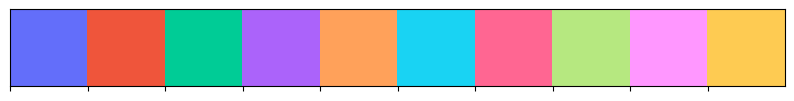

In [3]:
palette = px.colors.qualitative.Plotly

sns.palplot(palette)

---

Пример сетки, на которой будут проверяться новые слои

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./datasets', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./datasets', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_dataset.data.size(), train_dataset.targets.size()

In [5]:
class FlattenedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        image = image.view(-1)
        return image, label

In [6]:
train_dataset = FlattenedDataset(train_dataset)
test_dataset = FlattenedDataset(test_dataset)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

---

## Task 1

Это задание будет являться духовным наследником первого. Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой. На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. Однако все элементы, которые вы будете реализовывать, достаточно просты.

**Задача 1. (2 балла):** реализуйте слой BatchNorm (nn.BatchNorm).

**Задача 2. (2 балла):** реализуйте слой Linear (nn.Linear).

**Задача 3. (2 балла):** реализуйте слой Dropout(nn.Dropout)

**Задача 4. (2 балла):** реализуйте одно или более из:

- слой ReLU(nn.ReLU)
- слой Sigmoid(nn.Sigmoid)
- слой Softmax(nn.Softmax)

**Задача 5. (2 балла):** Вы получите по 1 дополнительному баллу за слой, если реализуете в рамках фреймворка из задания 3 прошлой работы.


---

### BatchNorm

In [8]:
class MyBatchNorm1d(nn.Module):

    def __init__(self, 
                 num_features: int, 
                 eps: float = 1e-8, 
                 momentum: float = 0.1
    ) -> None:
        super(MyBatchNorm1d, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('exp_avg_mean', torch.zeros(num_features))
        self.register_buffer('exp_avg_var', torch.ones(num_features))

    def __call__(self, input: torch.Tensor):
        # forward pass
        if self.training:
            if input.ndim == 2:
                dim = 0
            elif input.ndim == 3:
                dim = (0,1)
            input_mean = input.mean(dim, keepdim=True)
            input_var = input.var(dim, keepdim=True)
        else:
            input_mean = self.exp_avg_mean
            input_var = self.exp_avg_var
        x_hat = (input - input_mean) / torch.sqrt(input_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update the buffers (running mean and variance)
        if self.training:
            with torch.no_grad():
                self.exp_avg_mean = (1 - self.momentum) * self.exp_avg_mean + self.momentum * input_mean
                self.exp_avg_var = (1 - self.momentum) * self.exp_avg_var + self.momentum * input_var
        return self.out

### Linear

Реализация nn.Linear в [pytorch](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

Как работает [_calculate_fan_in_and_fan_out](https://github.com/pytorch/pytorch/blob/4557f6e339e7550b735067296ed479acc02e0487/torch/nn/init.py#L345)

In [9]:
class MyLinear(nn.Module):

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True
    ) -> None:
        super(MyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # kaiming normal init for ReLU
        self.weight = nn.Parameter(torch.empty((in_features, out_features)))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        gain = 2 ** 0.5
        torch.nn.init.normal_(self.weight, mean = 0, std = gain / (self.in_features ** 0.5))
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean = 0, std = gain / (self.in_features ** 0.5))

    def __call__(self, input: torch.Tensor):
        self.out = input.matmul(self.weight)
        if self.bias is not None:
            self.out += self.bias
        return self.out

### Dropout

Реализация в [Pytorch](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#dropout1d)

Реализация в [Pytorch (cpp)](https://github.com/pytorch/pytorch/blob/a1b22e369bed57990a57f9efbae201570ad6b824/aten/src/ATen/native/Dropout.cpp#L62)

In [10]:
class MyDropout1d(nn.Module):

    def __init__(self, p: float = 0.5, inplace: bool = False) -> None:
        super(MyDropout1d, self).__init__()
        if p < 0 or p > 1:
            raise ValueError(f"dropout probability has to be between 0 and 1, but got {p}")
        self.p = p
        self.inplace = inplace
        self.training = True # БУДЕТ ЛИ ИЗМЕНЯТЬСЯ В РЕЖИМЕ model.eval()?

    def __call__(self, input: torch.Tensor):
        if self.training:
            inp_dim = input.dim()
            if inp_dim not in (2, 3):
                raise RuntimeError(f"dropout1d: Expected 2D or 3D input, but received a {inp_dim}D input. ")
            # is_batched = inp_dim == 3
            # if not is_batched:
            #     input = input.unsqueeze_(0) if self.inplace else input.unsqueeze(0)
            if self.p == 1:
                return torch.zeros_like(input)
            probs = torch.full_like(input, self.p)
            mask = torch.bernoulli(probs, generator=torch_rng)
            self.out = input.mul(mask)
            return self.out
        else:
            return input

### ReLU

In [11]:
class MyReLU(nn.Module):

    def __init__(self):
        super(MyReLU, self).__init__()

    def __call__(self, input):
        self.out = torch.where(input > 0, input, 0)
        # self.out = torch.relu(input)
        return self.out

### Softmax

In [12]:
class MySoftmax(nn.Module):

    def __init__(self, dim: Optional[int] = None):
        super(MySoftmax, self).__init__()
        self.dim = dim if dim is not None else 1 # нужна логика получше

    def __call__(self, input):
        maxes = torch.max(input, dim=1, keepdim=True)[0]
        x_exp = torch.exp(input - maxes)
        x_exp_sum = torch.sum(x_exp, dim=self.dim, keepdim=True)
        self.out = x_exp / x_exp_sum
        return self.out

---

### Экспериментальная сеть

In [13]:
model_seq = nn.Sequential(
    MyLinear(784, 256),   # Flattened MNIST images (28x28) -> hidden layer
    MyBatchNorm1d(256),   # BatchNorm
    MyReLU(),             # ReLU activation
    MyDropout1d(p=0.5),    # Dropout layer
    MyLinear(256, 10),    # Hidden -> output layer (10 classes for MNIST)
    MySoftmax(dim=1)      # Softmax for classification
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_seq.parameters(), lr=0.001)

In [ ]:
# (784 * 256 + 256) + 256 * 2 + (256 * 10 + 10)
sum(p.numel() for p in model_seq.parameters())

In [15]:
def train_model_sequential(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

In [ ]:
train_model_sequential(model_seq, train_loader, criterion, optimizer)

In [ ]:
evaluate_model(model_seq, test_loader)

Торчевская аналогичная сеть для сравнения

In [18]:
model_seq = nn.Sequential(
    nn.Linear(784, 256),   # Flattened MNIST images (28x28) -> hidden layer
    nn.BatchNorm1d(256),   # BatchNorm
    nn.ReLU(),             # ReLU activation
    nn.Dropout1d(p=0.5),    # Dropout layer
    nn.Linear(256, 10),    # Hidden -> output layer (10 classes for MNIST)
    nn.Softmax(dim=1)      # Softmax for classification
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_seq.parameters(), lr=0.001)

In [ ]:
train_model_sequential(model_seq, train_loader, criterion, optimizer)

In [ ]:
evaluate_model(model_seq, test_loader)

----

---

## Task 2

Реализуйте медианный фильтр. Для текущего пикселя, пиксели, которые «попадают» в матрицу, сортируются, и выбирается медианное значение из отсортированного массива. Это значение и является выходным для текущего пикселя. Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

In [13]:
nino = Image.open('datasets/other/Nino.jpg')
# nino_t = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(nino)
nino_t = v2.PILToTensor()(nino)
# nino_t = v2.ToTensor()(nino)
nino_t.shape

torch.Size([3, 1200, 857])

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(nino_t.permute(1,2,0))
plt.show()

In [189]:
def add_salt_and_pepper(image: torch.Tensor, salt_p: float = 0.05, pepper_p: float = 0.05):
    # image: (C, H, W)

    noisy_image = image.clone(memory_format=torch.preserve_format)

    num_pixels = image[0].numel() # pixels in current picture (single channel)
    num_salt = int(salt_p * num_pixels)
    num_pepper = int(pepper_p * num_pixels)

    if image.max() <= 1.:
        black, white = 0., 1.
    elif image.max() <= 255:
        black, white = 0, 255

    for color, n in zip((white, black), (num_salt, num_pepper)):
        coords = (torch.randint(0, image.shape[1], (n,)),
                  torch.randint(0, image.shape[2], (n,)))
        for c in range(image.shape[0]):
            noisy_image[c, coords[0], coords[1]] = color

    return noisy_image


nino_t_noisy = add_salt_and_pepper(nino_t, 0.01, 0.01)

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(nino_t_noisy.permute(1,2,0))
plt.show()

# v2.ToPILImage()(nino_t_noisy)

[источник](https://gist.github.com/rwightman/f2d3849281624be7c0f11c85c87c1598)

[torch.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)

[torch.unfold](https://pytorch.org/docs/stable/generated/torch.Tensor.unfold.html)

In [192]:
# Pool in general, used as filter when stride = 1
class MedianFilter2d(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianFilter2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        # x = (batch_size, channels, height, width)

        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        x = F.pad(x, self._padding(x), mode='reflect')
        print(x.shape)
        
        # sliding over height (dim=2), then over width (dim=3)
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        print(x.shape)
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        print(x.shape)
        return x

In [ ]:
median_filter = MedianFilter2d(3, 1, 0, True)
nino_result_3 = median_filter(nino_t.unsqueeze(0)).squeeze()

median_filter = MedianFilter2d(5, 1, 0, True)
nino_result_5 = median_filter(nino_t.unsqueeze(0)).squeeze()

median_filter = MedianFilter2d(10, 1, 0, True)
nino_result_10 = median_filter(nino_t.unsqueeze(0)).squeeze()

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(16, 20))
ax = ax.ravel()

for i, (kernel_size, img) in enumerate(zip(('no', 3, 5, 10), (nino_t, nino_result_3, nino_result_5, nino_result_10))):
    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(f'Nino (kernel size = {kernel_size})', fontsize=16)
    
plt.show()

# transforms.v2.ToPILImage()(nino_result_3)

---

---

## Task 3

Реализуйте следующие классы (указана сигнатура *init*):

- BaseTransform(p: float) [базовый класс для всех трансформаций]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor()
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других. При вызове метода call он должен последовательно вызывать трансформации из списка. При вызове каждого из них с вероятностью p должно применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже. Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

torch.nn использовать нельзя!

{*} (1 балл) Протестируйте ваши классы на воспроизводимость, результат, граничные случаи.

### BaseTransform

In [27]:
class BaseTransform:
    
    def __init__(self, p: float, seed: int = SEED):
        self.p = p
        self._rng = np.random.default_rng(SEED)

    def __call__(self, img: Image.Image) -> Image.Image:
        if self._rng.uniform(0, 1) < self.p:
            return self.apply(img)
        return img

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError("Each transform should implement the apply method.")

### RandomCrop

[PIL crop](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop)

In [307]:
class RandomCrop(BaseTransform):

    def __init__(
            self, 
            p: float, 
            size: Union[int, Sequence[int]] | None = None,
            box: tuple[float, float, float, float] | None = None,
            crop_scale: float | None = None
    ) -> None:
        super(RandomCrop, self).__init__(p)
        self.size = size
        self.box = box
        self.crop_scale = crop_scale

    def apply(self, img: Image.Image) -> Image.Image:
        if self.box is None:
            width, height = img.size
            if self.size is not None:
                if isinstance(self.size, int) or len(self.size) == 1:
                    crop_w, crop_h = self.size, self.size
                elif len(self.size) == 2:
                    crop_w, crop_h = self.size[0], self.size[1]
            else:
                if self.crop_scale is None:
                    crop_scale = self._rng.uniform(0.3, 0.9)
                else:
                    crop_scale = self.crop_scale

                crop_w = self._rng.integers(width * crop_scale, width)
                crop_h = self._rng.integers(height * crop_scale, height)

            if width < crop_w or height < crop_h:
                raise ValueError("Crop size must be smaller than the image dimensions.")
            
            l = self._rng.integers(low = 0, high = width - crop_w)
            t = self._rng.integers(low = 0, high = height - crop_h)
            r = l + crop_w
            d = t + crop_h

            return img.crop((l, t, r, d))
        else:
            return img.crop(self.box)

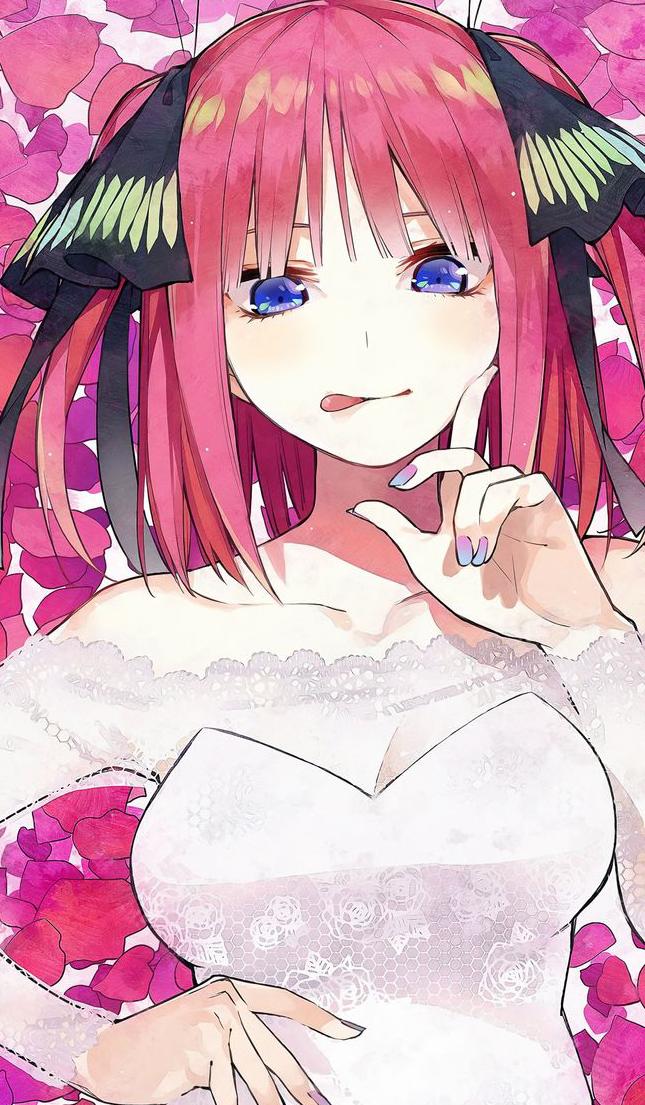

In [308]:
RandomCrop(1)(nino)

### RandomRotate

In [309]:
class RandomRotate(BaseTransform):

    def __init__(
            self,
            p: float = 0.5,
            angle: float | None = None,
            resample: int = 0,
            expand: bool = False,
            center: tuple[float, float] | None = None,
            translate: tuple[int, int] | None = None,
            fillcolor: float | tuple[float, ...] | str | None = None
    ) -> None:
        super(RandomRotate, self).__init__(p)
        self.angle = angle
        self.resample = resample
        self.expand = expand
        self.center = center
        self.translate = translate
        self.fillcolor = fillcolor

    def apply(self, img: Image.Image) -> Image.Image:
        if self.angle is None:
            self.angle = self._rng.uniform(0, 360)

        params = {key: value for key, value in self.__dict__.items() 
                  if key not in ['p', '_rng']}
        # Костыль для того, чтобы угол обновлялся от картинки к картинке для одного и того же
        # инстанса класса
        self.angle = None

        return img.rotate(**params)

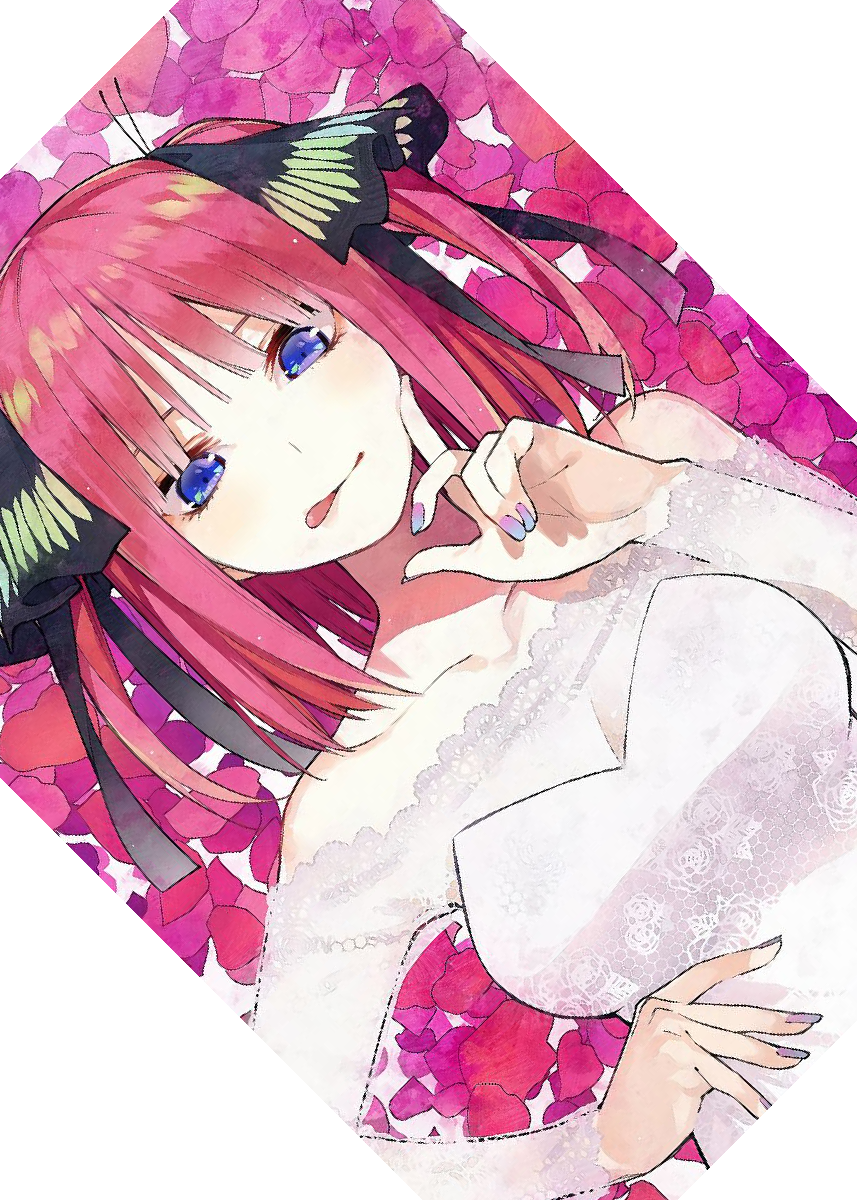

In [310]:
RandomRotate(1, 45, fillcolor=(255,255,255))(nino)

### RandomZoom

In [311]:
class RandomZoom(BaseTransform):

    def __init__(
            self, p: float, 
            zoom_factor: float | None = None,
            zoom_point: tuple[float, float] | None = None
    ) -> None:
        super().__init__(p)
        self.zoom_factor = zoom_factor
        self.zoom_point = zoom_point

    def apply(self, img: Image.Image) -> Image.Image:
        if self.zoom_factor is None:
            zoom_factor = self._rng.uniform(0, 5)
        else:
            zoom_factor = self.zoom_factor

        width, height = img.size
        new_width, new_height = int(width * zoom_factor), int(height * zoom_factor)

        if self.zoom_point is None:
            # zoom_x, zoom_y = (width // 2, height // 2) # середина изображения
            zoom_x = self._rng.integers(0, width)
            zoom_y = self._rng.integers(0, height)
        else:
            zoom_x = self.zoom_point[0]
            zoom_y = self.zoom_point[1]

        if zoom_factor < 1.0:
            
            img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

            # TODO: добавить отдаление от конкретной точки, пока только от середины
            pad_left = (width - new_width) // 2
            pad_top = (height - new_height) // 2
            pad_right = width - new_width - pad_left
            pad_bottom = height - new_height - pad_top

            img = ImageOps.expand(img, (pad_left, pad_top, pad_right, pad_bottom))
            
        elif zoom_factor > 1.0:

            crop_width = int(width / zoom_factor)
            crop_height = int(crop_width / (width / height))

            left = max(0, zoom_x - crop_width // 2)
            right = min(width, zoom_x + crop_width // 2)
            top = max(0, zoom_y - crop_height // 2)
            bottom = min(height, zoom_y + crop_height // 2)

            if right - left < crop_width:
                if left == 0:
                    right = crop_width
                elif right == width:
                    left = width - crop_width
            if bottom - top < crop_height:
                if top == 0:
                    bottom = crop_height
                elif bottom == height:
                    top = height - crop_height

            img = img.crop((left, top, right, bottom))
            img = img.resize((width, height), Image.Resampling.LANCZOS)

        return img

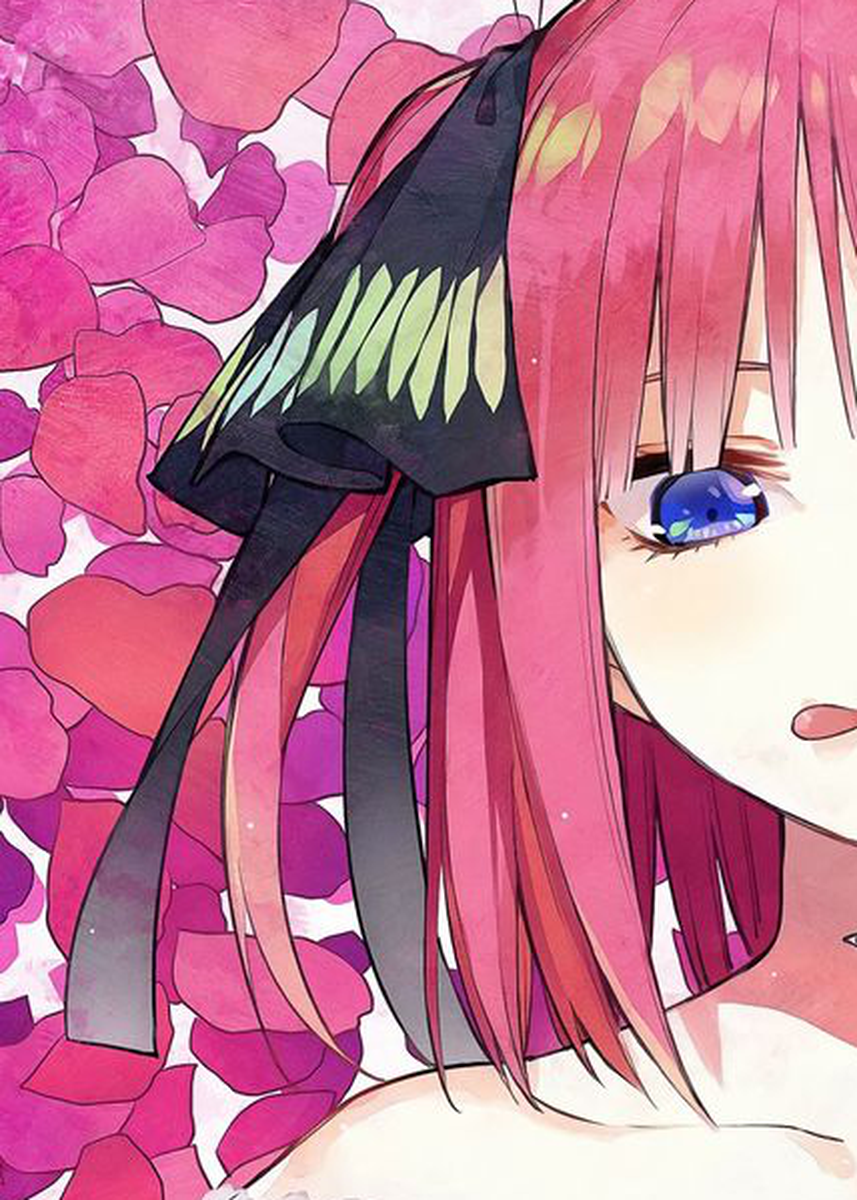

In [312]:
RandomZoom(1, 2, (100, 400))(nino)

### ToTensor

In [336]:
class ToTensor:
    def __call__(self, img: Image.Image, normalize: bool = False) -> torch.Tensor:
        img_array = np.array(img)
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)
        if normalize:
            img_tensor /= 255.0
        return img_tensor

In [337]:
ToTensor()(nino).shape

torch.Size([3, 1200, 857])

### Compose

In [338]:
class Compose(BaseTransform):
    def __init__(self, transforms: list[BaseTransform]):
        super(Compose, self).__init__(1)
        self.transforms = transforms

    def apply(self, img: Image.Image) -> torch.Tensor:
        for transform in self.transforms:
            img = transform(img)
        return img

In [339]:
transforms = Compose([
        RandomCrop(p=1),
        RandomRotate(p=1),
        RandomZoom(p=1),
        ToTensor()
    ])

In [340]:
compose_result = transforms(nino)
compose_result.shape

torch.Size([3, 1105, 645])

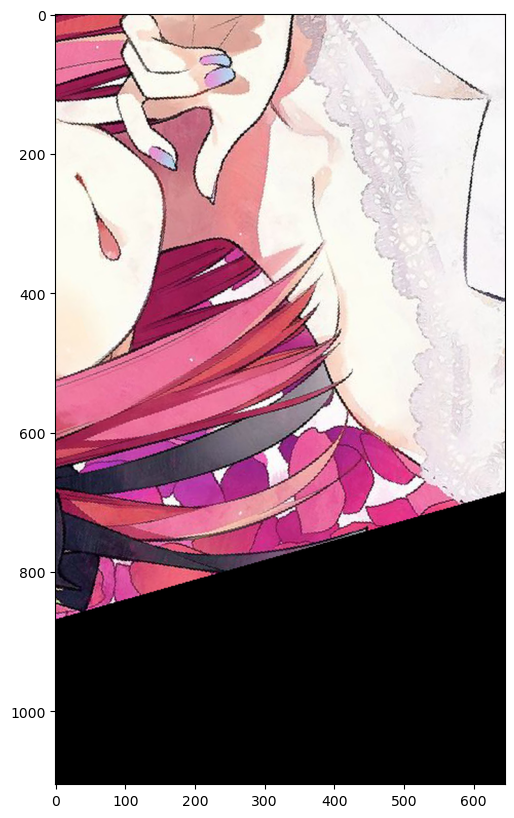

In [341]:
plt.figure(figsize=(8, 10))
plt.imshow(compose_result.permute(1,2,0))
plt.show()

# v2.ToPILImage()(nino_t_noisy)